In [ ]:
%matplotlib inline

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import sqlite3

project_name = 'mongo'

con = sqlite3.connect('main.db')

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
order by 2
'''
raw_releases = con.execute(sql).fetchall()

import re
from dataclasses import dataclass, field
majormin_pat = re.compile(
    r'(?P<pre>  .*?)'   # optional before major
    r'(?P<majormin>  [0-9]+\.[0-9]+)'  # major.minor ex "1.2"
    r'(?P<post>  .*)',   # optional micro and afterwards
    re.VERBOSE
    )
@dataclass
class Release:
    raw_label: str
    majormin: str = field(init=False)
    raw_date: str
    date: datetime = field(init=False, default=None)

    def __post_init__(self):
        self.majormin = None
        if match := majormin_pat.search(self.raw_label):
            post = match.group('post')
            if not post.startswith('.0'):
                # print(f'Ignore micro ({self.raw_label}=)')
                return # raise ValueError(f'Ignore micro ({self.raw_label}=)')
            self.majormin = match.group('majormin')
        else:
            print(f'No major.minor ({self.raw_label}=)')
            return

        self.date = datetime.strptime(self.raw_date, "%Y-%m-%d")
        
# rel = Release('v1.2.0-post', raw_date='2021-02-03')
# assert 0, rel

raw_releases = [Release(tag, date) for tag,date in raw_releases]
print(f'{len(raw_releases)=}')
# assert 0, [raw_releases[:3]]


No major.minor (idxv1=)
No major.minor (show=)
len(raw_releases)=731


len(releases)=34


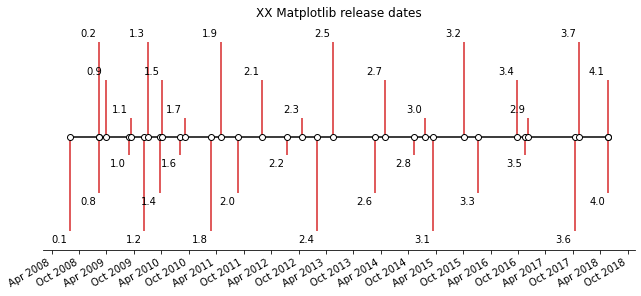

In [39]:
# show only the first major.minor; ignore RC and all other micro versions
releases = []
already_seen = set()
for rel in raw_releases:
        mm = rel.majormin
        if mm in already_seen:
                continue
        # TODO: skip micro releases
        if not rel.date:
                # print(f'?? {rel=}')
                continue
        already_seen.add(mm)
        releases.append(rel)
print(f'{len(releases)=}')
# assert 0, releases[:3]

# Choose some nice levels
raw_levels = [-5, 5, -3, 3, -1, 1]
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(releases)/6)))[:len(releases)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
ax.set(title="XX Matplotlib release dates")

dates = [rel.date for rel in releases]
if 1:
        # The vertical stems.
        ax.vlines(dates, 0, levels, color="tab:red")  

# Baseline and markers on it.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  

# annotate lines
line_style = dict(textcoords="offset points",
                        horizontalalignment="right")
for num,rel in enumerate(releases):
        level = raw_levels[num % len(raw_levels)]
        valign = "bottom" if level > 0 else "top"
        xytext = (-3, np.sign(level)*3)
        ax.annotate(rel.majormin, xy=(rel.date, level),
                        xytext=xytext,
                        verticalalignment=valign,
                        **line_style)

# format xaxis with 4 month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

.. admonition:: References

   The use of the following functions, methods, classes and modules is shown
   in this example:

   - `matplotlib.axes.Axes.annotate`
   - `matplotlib.axes.Axes.vlines`
   - `matplotlib.axis.Axis.set_major_locator`
   - `matplotlib.axis.Axis.set_major_formatter`
   - `matplotlib.dates.MonthLocator`
   - `matplotlib.dates.DateFormatter`

